In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
INPUT_SHAPE = (256, 256)
CHANNEL = 3
MODEL_NAME = "model3"
IMAGE_PATH = "./datasets/test/manydogs.jpeg"
IMAGE_NAME = IMAGE_PATH.split("/")[3]

# Introduction

This procedure consist on obtaining how important the ontributions of each of the channels when finding the class the object belongs to.

With this procedure we are able to understand which parts of the images producce the most amount of activations

# load the models

In [3]:
model = tf.keras.models.load_model(f"./checkpoints/{MODEL_NAME}/")

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



In [4]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 1st_set_1st_conv_3x3 (Conv2  (None, 254, 254, 4)      112       
 D)                                                              
                                                                 
 1st_set_2nd_conv_3x3 (Conv2  (None, 252, 252, 4)      148       
 D)                                                              
                                                                 
 1st_set_3rd_conv_3x3 (Conv2  (None, 250, 250, 4)      148       
 D)                                                              
                                                                 
 1st_max_pooling (MaxPooling  (None, 125, 125, 4)      0         
 2D)                                                       

In [5]:
# Last layer

if MODEL_NAME == "esp32" or MODEL_NAME == "model1":
    last_layer_conv = "2nd_conv_3x3"

if MODEL_NAME == "model2":
    last_layer_conv = "5th_conv_3x3"

if MODEL_NAME == "model3":
    last_layer_conv = "5th_set_3rd_conv_3x3"

In [6]:
last_layer_conv_output = model.get_layer(last_layer_conv).output

In [7]:
last_conv_model = tf.keras.Model(inputs=model.input, outputs=last_layer_conv_output)

In [8]:
last_conv_model.output.shape

TensorShape([None, 4, 4, 64])

In [9]:
last_conv_model.output.shape[1:]

TensorShape([4, 4, 64])

In [10]:
# We get a model that will take the output of the last convolutional layer and produce a prediction
classification_model_input = tf.keras.Input(shape=last_conv_model.output.shape[1:])
#Shape must be rank 4 but is rank 5 for '{{node 2nd_max_pooling/MaxPool}} we need [1:] to avoid the miss shape error given by the batch being the first dimension

# layers needed to get a classification out of the last convolutional layer
classification_layers = ["features_vector", "sigmoid_output"]
if MODEL_NAME == "esp32":
    classification_layers.insert(0, "2nd_max_pooling")

x = classification_model_input
#Build the graph from the output of the last model to the classification layer model
for layer in classification_layers:
    x = model.get_layer(layer)(x)

classification_model_output = tf.keras.Model(inputs=classification_model_input, outputs=x)

In [11]:
classification_model_output.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 4, 64)]        0         
                                                                 
 features_vector (GlobalMaxP  (None, 64)               0         
 ooling2D)                                                       
                                                                 
 sigmoid_output (Dense)      (None, 1)                 65        
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [12]:
#load a sample image

image = tf.keras.utils.load_img(IMAGE_PATH, color_mode="rgb" if CHANNEL==3 else "grayscale", target_size=(INPUT_SHAPE))
image_vector = tf.keras.utils.img_to_array(image)

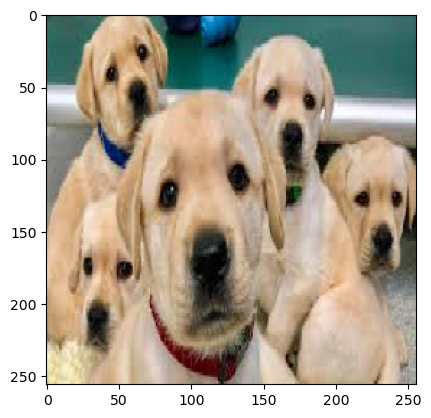

In [13]:
image_vector/=256
plt.imshow(image_vector)

In [14]:
image_vector = np.expand_dims(image_vector, axis=0)

In [15]:
with tf.GradientTape() as tape:
    last_conv_activation = last_conv_model(image_vector)
    tape.watch(last_conv_activation)
    classfication_output = classification_model_output(last_conv_activation)
    top_pred_index = tf.argmax(classfication_output[0])
    top_class_channel = classfication_output[:, top_pred_index]

activation_gradient = tape.gradient(top_class_channel, last_conv_activation)

In [16]:
# Gradient corresponding to the last convolutional layer when applied to the classification output

activation_gradient[0].shape

TensorShape([4, 4, 64])

In [17]:
# activation_gradient = activation_gradient[0].numpy()

In [18]:
# Average on for channel
# average_gradient_activation = np.average(activation_gradient, axis=2)

In [19]:
# average_gradient_activation.shape

In [20]:
# pooling chanel importance

In [21]:
pooled_grads = tf.reduce_mean(activation_gradient, axis=(0, 1, 2)).numpy()
last_conv_activation = last_conv_activation.numpy()[0]

In [22]:
pooled_grads.shape

(64,)

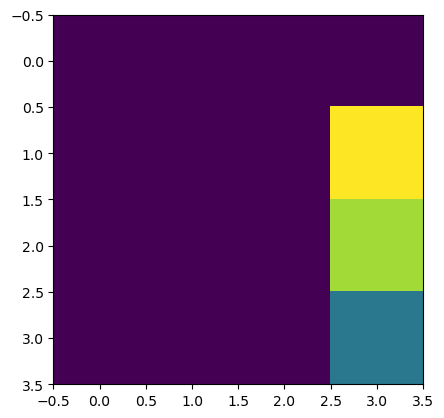

In [23]:
# Weight the values from the last activation 
for i in range(pooled_grads.shape[-1]):
    last_conv_activation[:, :, i] *= pooled_grads[i]

#get the average value per channel
heathmap = np.mean(last_conv_activation, axis=-1)

#remove negative values
heathmap = np.maximum(heathmap, 0)

# scale values of the heatmap to keep it between 0 - 1
heathmap /= np.max(heathmap)

plt.imshow(heathmap)

In [24]:
# import matplotlib.cm as cm

# jet = cm.get_cmap("jet")

# jet_colors = jet(np.arange(256))[:, :CHANNEL]

/var/folders/8s/wcgky8714x9115n0kp3x7ysm0000gn/T/ipykernel_77902/1943637338.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


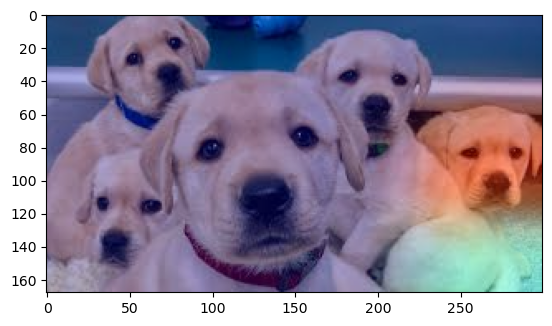

In [25]:
import matplotlib.cm as cm

image = tf.keras.utils.load_img(IMAGE_PATH, color_mode="rgb" if CHANNEL==3 else "grayscale")
image = tf.keras.utils.img_to_array(image)

heathmap = np.uint(255 * heathmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :CHANNEL]
jet_heatmap = jet_colors[heathmap]

jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

# Combine heatmal with the image superpose both
superimpose_img = jet_heatmap * 0.6 + image
superimpose_img = tf.keras.utils.array_to_img(superimpose_img)

save_path = f"./heatmaps-part3/{IMAGE_NAME}_{MODEL_NAME}.jpg"
superimpose_img.save(save_path)

plt.imshow(superimpose_img)